# Workshop 2.7: Extreme temperature

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Extreme Value Analysis, Week 2.7, Wednesday, Jan 8, 2024.*

In this session, you will work with the uncertainty of extreme temperatures in the airport of Barcelona to assess the extreme loads induced by temperature in a steel structure in the area. You have daily observations of the maximum temperature for several years. The dataset was retrieved from the Spanish Agency of Metheorology [AEMET](https://www.aemet.es/es/portada). Your goal is to design the structure for a _lifespan of 50 years_ with a _probability of failure of 0.1_ during the design life. 

**The goal of this project is:**
1. Compute the required design return period for the steel structure.
2. Perform monthly Block Maxima and fit the a distribution to the sampled observations.
3. Assess the Goodness of fit of the distribution.
4. Compute the return level plot.
5. Compute the design return level.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats 
from math import ceil, trunc

plt.rcParams.update({'font.size': 14})

## Task 1: Data Exploration

First step in the analysis is exploring the data, visually and through its statistics. We import the dataset and explore its columns.

In [2]:
T = pd.read_csv('temp.csv', delimiter = ',', parse_dates = True).dropna().reset_index(drop=True)
T.columns=['Date', 'T'] #rename columns
T.head()

,Date,T
0,5/7/13,25.3
1,5/8/13,22.9
2,5/9/13,23.0
3,5/10/13,20.4
4,5/11/13,20.1


The dataset has two columns: the time stamp of the measurements and the cumulative daily precipitation. We set the first columns as a datetime as they are the dates of the measurements.

In [3]:
T['Date'] = pd.to_datetime(T['Date'], format='mixed')
T['Date']

0      2013-05-07
1      2013-05-08
2      2013-05-09
3      2013-05-10
4      2013-05-11
          ...    
3904   2024-10-27
3905   2024-10-28
3906   2024-10-29
3907   2024-10-30
3908   2024-10-31
Name: Date, Length: 3909, dtype: datetime64[ns]

Once formatted, we can plot the timeseries and the histogram.

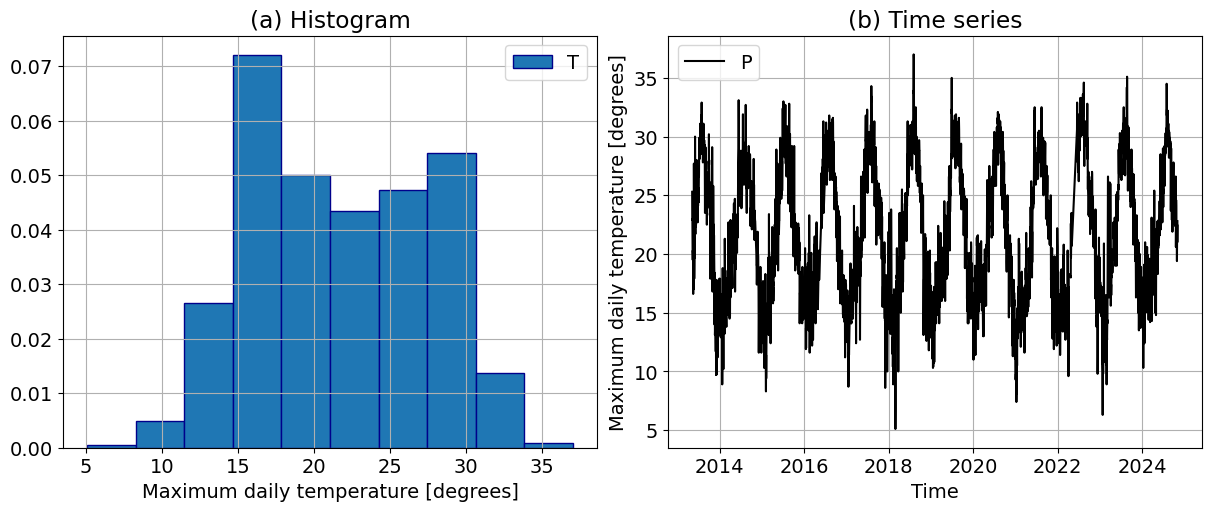

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12,5), layout='constrained')

axes[0].hist(T['T'], label = 'T', density = True, edgecolor = 'darkblue')
axes[0].set_xlabel('PDF')
axes[0].set_xlabel('Maximum daily temperature [degrees]')
axes[0].grid()
axes[0].legend()
axes[0].set_title('(a) Histogram')

axes[1].plot(T['Date'], T['T'],'k', label = 'P')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Maximum daily temperature [degrees]')
axes[1].grid()
axes[1].set_title('(b) Time series')
axes[1].legend()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.1:</b>   
Based on the above plots, briefly describe the data.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    
The histogram shows maximum monthly temperatures with a median around 20 degrees, indicating that they belong to a warm climate, such as the Spanish one. The variability is significant since these temperatures can vary from 5 to more than 35 degrees.

Regarding the timeseries, it is possible to observe the seasons. Every year there is a cycle with temperatures moving up and down in a sinusoidal shape. Therefore, this data presents seasonality.
</div>
</div>

## Task 2: Sample Monthly Maxima

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.2:</b>   
Sample monthly maxima from the timeseries and plot them on the timeseries. Plot also the histograms of both the maxima and the observations.
</p>
</div>

In [11]:
# Extract year and month from the Date column
T['Year'] = T['Date'].dt.year
T['Month'] = T['Date'].dt.month

# Group by Year and Month, then get the maximum observation
idx_max = T.groupby(['Year', 'Month'])['T'].idxmax().reset_index(name='Index').iloc[:, 2]
max_list = T.loc[idx_max]

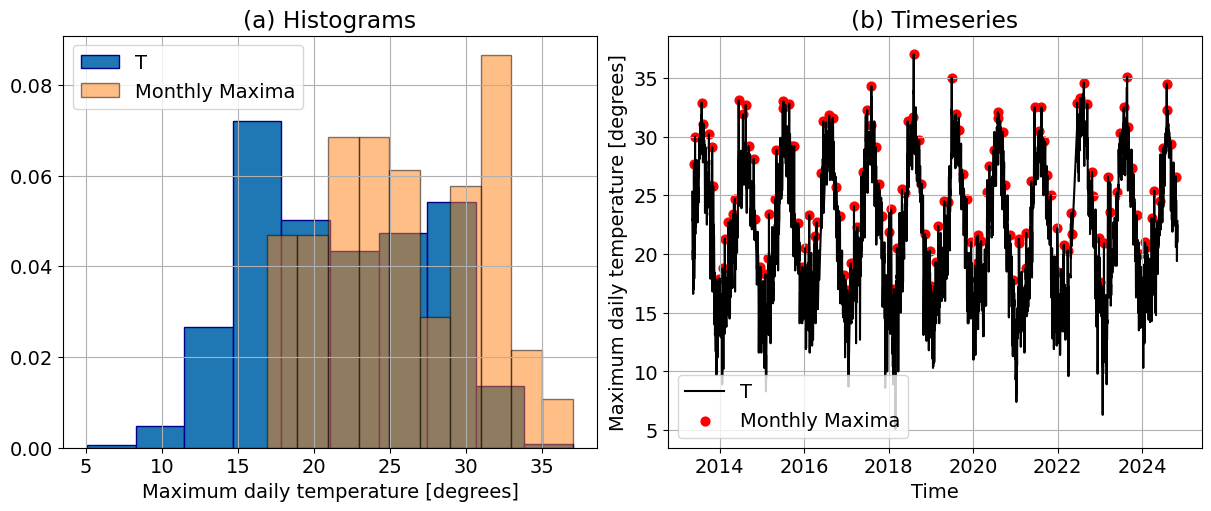

In [14]:
#Plot

fig, axes = plt.subplots(1,2, figsize=(12,5), layout='constrained')

axes[0].hist(T['T'], label = 'T', density = True, edgecolor = 'darkblue')
axes[0].hist(max_list['T'], label = 'Monthly Maxima',  density = True, edgecolor = 'k', alpha = 0.5)
axes[0].set_xlabel('PDF')
axes[0].set_xlabel('Maximum daily temperature [degrees]')
axes[0].grid()
axes[0].set_title('(a) Histograms')
axes[0].legend()

axes[1].plot(T['Date'], T['T'],'k', label = 'T')
axes[1].scatter(max_list['Date'], max_list['T'], 40, 'r', label = 'Monthly Maxima')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Maximum daily temperature [degrees]')
axes[1].set_title('(b) Timeseries')
axes[1].grid()
axes[1].legend()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.3:</b>   
Look at the previous plots. Are the sampled maxima independent and identically distributed? Justify your answer. What are the implications for further analysis?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    
The observations are independent as we have sampled monthly maxima. This is, several days or weeks happen between the observations which should ensure the independence between them.

The observations are NOT identically distributed. We can see in the plot above that there is seasonality. The distribution of temperature during the summer months is not the same as during the winter months so we cannot assume stationarity. Therefore, **we are violating one of the assumptions of EVA and cannot rely on the results**. One possible solution is to move from monthly maxima to yearly maxima, where the problem of seasonality does not occur.

Here, we will continue with the analysis to show the procedure but in practice you should go for a non-stationary method (more advanced, out of the scope of this course), move to a scale when you do not have such seasonality (yearly in this case) or use another sampling approach that does not depend on time windows such as Peak Over Threshold.
</div>
</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.3:</b>   
Compute PDF and the empirical cumulative distribution function of the observations and the sampled monthly maxima. Plot the ECDF in log-scale. Where are the sampled monthly maxima located with respect with the CDF of all the observations?
</p>
</div>

In [54]:
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

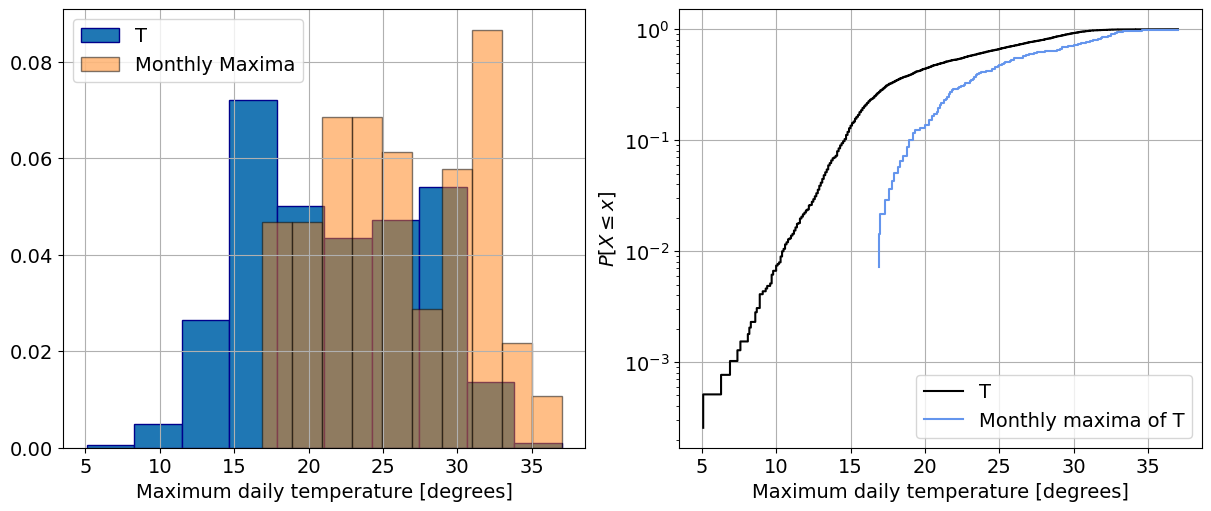

In [71]:

fig, axes = plt.subplots(1,2, figsize=(12,5), layout='constrained')

axes[0].hist(T['T'], label = 'T', density = True, edgecolor = 'darkblue')
axes[0].hist(max_list['T'], label = 'Monthly Maxima',  density = True, edgecolor = 'k', alpha = 0.5)
axes[0].set_xlabel('PDF')
axes[0].set_xlabel('Maximum daily temperature [degrees]')
axes[0].grid()
axes[0].legend()

axes[1].step(ecdf(T['T'])[1],
         ecdf(T['T'])[0],'k', label = 'T')
axes[1].step(ecdf(max_list['T'])[1],
         ecdf(max_list['T'])[0],
         'cornflowerblue', label = 'Monthly maxima of T')
axes[1].set_xlabel('Maximum daily temperature [degrees]')
axes[1].set_ylabel('${P[X \leq x]}$')
axes[1].grid()
axes[1].set_yscale('log')
axes[1].legend();

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    
The maxima observations are located at the right tail of the distribution of the observations.
</div>
</div>

## Task 3: Distribution Fitting

We did this a lot at the end of Q1---refer to your previous work as needed!

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 3:</b>   
Fit a distribution to the monthly maxima. Print the values of the obtained parameters and interpret them:
<ol>
    <li>Do the location and scale parameters match the data?</li>
    <li>According to the shape parameter, what type of distribution is this?</li>
    <li>What type of tail does the distribution have (refer to EVA Chapter 7.2 of the book)?</li>
    <li>Does the distribution have an upper bound? If so, compute it!</li>
</ol>
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Use <a href="https://docs.scipy.org/doc/scipy/reference/stats.html" target="_blank">scipy.stats</a> built in functions (watch out with the parameter definitions!), similar to Week 1.7 and use the DataFrame created in Task 2.
</p></div>

In [72]:
params_T = stats.genextreme.fit(max_list['T'])
print(params_T)

(0.31862922861766707, 24.264924258955915, 5.008246484907248)


<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    
The order of the parameters returned from scipy.stats is shape, location, and scale, so shape = 0.32, location = 24.26 and scale = 5.01. Note that the <a html="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html" target="_blank">genextreme method of scipy.stats</a> defines the PDF of the distribution with a negative shape parameter $c$, relative to the definition in our book ($\xi$, shown <a html="https://mude.citg.tudelft.nl/book/eva/GEV.html" target="_blank">here</a>). Thus, shape parameter is negative (according to our book) and the obtained GEV is a Reverse Weibull with a upper bound in loc-scale/shape = 24.26 + 5.01/0.32 = 39.92.
</div>
</div>

## Task 4: Goodness of Fit

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 4:</b>   
Assess the goodness of fit of the selected distribution using the exceedance probability plot in semi-log scale.
    
Consider the following questions:
<ol>
    <li>How well do the probabilities of the fitted distribution match the empirical distribution? Is there an over- or under-prediction?</li>
    <li>Is the tail type of this GEV distribution appropriate for the data?</li>

</ol>

</p>
</div>

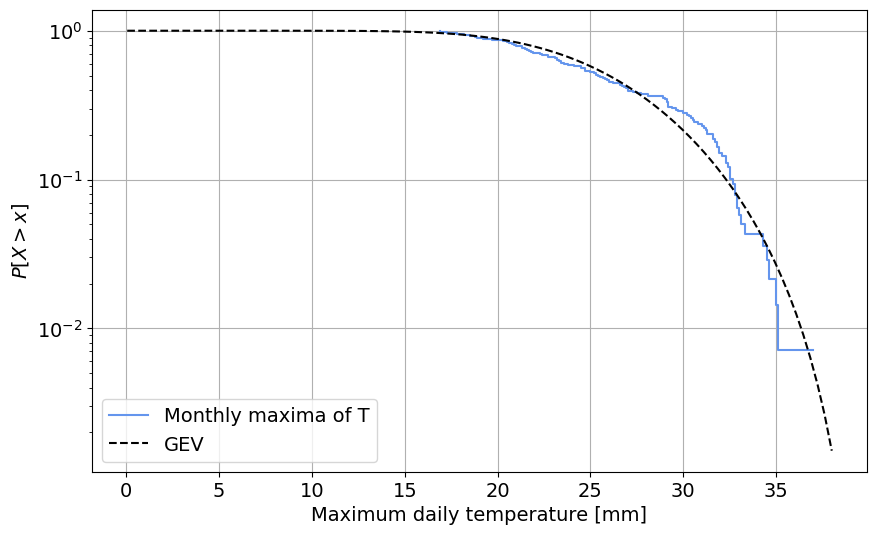

In [74]:
x_range = np.linspace(0.05, 38, 100)
plt.figure(figsize=(10, 6))
plt.step(ecdf(max_list['T'])[1], 1-ecdf(max_list['T'])[0],'cornflowerblue', label = 'Monthly maxima of T')
plt.plot(x_range, 1-stats.genextreme.cdf(x_range, *params_T),
             '--k', label='GEV')
plt.xlabel('Maximum daily temperature [mm]')
plt.ylabel('${P[X > x]}$')
plt.yscale('log') 
plt.grid()
plt.legend();

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>
       
<ol>
    <li>The probabilities seem to match OK, no clear over or under-prediction. </li>
    <li>The bounded tail looks appropriate for the data.</li>
</ol>
</div>
</div>

## Task 5: Return Levels

It was previously indicated that the structure should be designed for a lifespan of 50 years with a probability of failure of 0.1 along the design life.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5.1:</b>   

Compute the design return period using both the Binomial and Poisson model for extremes. Compare the obtained return.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>
    
Using the Binomial model:

$
RT = \frac{1}{1-(1-p_{f,DL})^(1/DL)} = \frac{1}{1-(1-0.1)^(1/50)} = 475.04 \ years
$

Using the Poisson model:

$
RT = \frac{-DL}{ln(1-p_{f,DL})} = \frac{-50}{ln(1-0.1)}= 474.56\ years
$

Both models provide similar results.
</div>
</div>

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5.2:</b>   

Considering that you have sampled monthly maxima, compute and plot the return level plot: values of the random variable in the x-axis and return periods on the y-axis. Y-axis in logscale.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>The three missing variables listed below are all type <code>numpy.ndarray</code>; the last is found using your <code>scipy.stats</code> distribution from Task 3.
</p></div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Solution:</b>
    
The return period from the previous task is defined and converted to a probability, then the design value is found using the inverse CDF.
    
Note that the number of maxima per year is 12 (12 months/year) so we need to take it into account when computing the probabilities.
    
Note the unpacking of the distribution parameters, <code>*params_P</code>, which keeps the syntax simple for the GEV distribution.
</div>
</div>

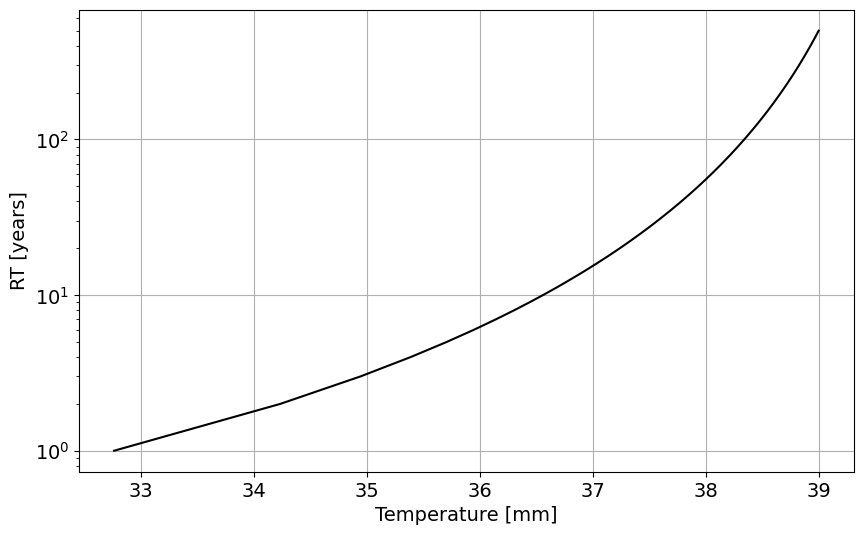

In [84]:
RT_range = np.linspace(1, 500, 500)
monthly_probs = 1/(RT_range*12)
eval_nitrogen = stats.genextreme.ppf(1-monthly_probs, *params_T)

plt.figure(figsize=(10, 6))
plt.plot(eval_nitrogen, RT_range, 'k')
plt.xlabel('Temperature [mm]')
plt.ylabel('RT [years]')
plt.yscale('log') 
plt.grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5.3:</b>   
Compute the design value of nitrogen. Choose the return level you prefer within the Poisson and Binomial model.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Solution:</b>
    
The return period from the previous task is defined and converted to an <em>exceedance</em> probability, then the design value is found using the inverse CDF.
        
Note the unpacking of the distribution parameters, <code>*params_T</code>, which keeps the syntax simple for the GEV distribution.
</div>
</div>

In [80]:
RT_design = 475
monthly_design = 1/(RT_design*12)
design_T = stats.genextreme.ppf(1-monthly_design, *params_T)

print('The design value of temperature is:',
      f'{design_T:.3f}')

The design value of temperature is: 38.984


**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.